In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [328]:
import os
from os.path import exists, join as pjoin, realpath
NBROOT = realpath(os.curdir)

import logging
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('PIL').level = logging.INFO # PIL.PngImagePlugin

import sys
sys.path.append(realpath('..'))
sys.path.append(realpath('../../eslope/development/src'))

import json
from pathlib import Path
from time import time
from urllib.error import HTTPError
from urllib.request import urlopen, urlretrieve
from subprocess import check_call, CalledProcessError

try:
    # like os.system but with live output
    from IPython.utils.process import system
    def check_run(cmd):  # type:ignore
        r = system(cmd)
        if r: raise CalledProcessError(r, cmd)
        return r
except ImportError:
    def check_run(cmd):
        return check_call(cmd, shell=True)

#external
#!pip install shapely
import shapely
from shapely.geometry import mapping, shape, GeometryCollection, Polygon, Point
from shapely.ops import cascaded_union
import numpy as np
from IPython.display import display, Image as DImage
from PIL import Image as Img
import mercantile as T
from osgeo import gdal
gdal.UseExceptions()


# own
import mbt_util as M
import bbox
from mbt_util import mbt_merge, mbt_info
from src import img_util as G, geometry as GY, \
    mbt_download as MD, mbt_partial as MP, mbt_pyramid as MY, swisstopo as SS
from src.jpg_quality_pil_magick import get_jpg_quality
import src.mbt_jpg_debloat as MJD


In [4]:
mbtnames_fr = {
    1: 'IGNt1-Mercantour-Ubaye-Antibes-Embrun.mbtiles',  # 1.3GB
    # Préalpes, Trois-Evéchés, Pelat, Mercantour-Argentera, Parpaillon, Chambeyron
    2: 'IGNt2-Digne-Aups-Eguilles-Gap.mbtiles',  # 1.3 GB
    # Préalpes de Digne, Lubéron, Vaucluse, Baronnies, Bochaine, Diois-S
    3: 'IGNt3-Vercors-Ecrins-Cerces.mbtiles',  # 1.2
    # Vercors, Taillefer, Dévoluy, Ecrins, Cerces, Queyras, Escreins
    # coupé en 2 t3/t4: Grandes Rousses, Arves, Cerces
    4: 'IGNt4-Chartreuse-Vanoise Chambery-Bardon.mbtiles',  # 1 GB
    # Chartreuse, Belledonne, Grandes Rousses N, Arves N, Cerces N, Lauzière, Vanoise, Mont-Cenis
    5: 'IGNt5-MontBlanc-Chambery-Evian.mbtiles'  # 1.1 GB
    # Bauges, Beaufortain, Bornes, Aravis, Mont-Blanc, Aiguilles Rouges, Giffre, Chablais
}
mbtnames_merged = {
    1: 'alps1-Mercantour-Ubaye-Cuneese',
    2: '',  # IGNt2 - no change
    3: 'alps3-Vercors-Ecrins-Queyras-Cozie',
    # it3: Alpes Cozie (Cotiennes) ; Monviso
    4: 'alps4-Grenoble-Savoie-Susa-Lanzo-GParadiso',
    # Chartreuse, Belledonne, Grandes Rousses N, Arves N, Cerces N, Lauzière, Vanoise, Mont-Cenis
    # it: Alpes Grées/Alpi Graie: Lanzo, Susa
    5: 'alps5-Mont-Blanc-Leman-Cervino-Cogne'
    # it: Gran Paradiso N, Cervino
}

In [5]:
# This could be useful to restrict the area to merge to speed it up
border_zones = {
    4: dict(west=6.62, east=7.19),
    3: dict(west= 6.64, east=7.08),
    1: dict(west=6.85, east=7.72)  # instead of 8.174 for bug
}

In [6]:
fritN = 4
workdir4 = f'frit{fritN}/'
os.makedirs(workdir4, exist_ok=True)

orig = pjoin(realpath('../../mapdata/mobac_atlases'), mbtnames_fr[fritN])
mbtfr4 = pjoin(workdir4, f'fr{fritN}.mbtiles')
!ln -sf "$orig" "$mbtfr"
M.mbt_info(mbtfr4)

'zoom = 9 16 ; n = 49153 * 20 kb/tile q = 75 ; bounds = 5.625,45.089,7.732,45.583 ; format = jpg ; name = IGNt4-Chartreuse-Vanoise Chambery-Bardon'

In [7]:
finalname = mbtnames_merged[fritN]
finalpath4 = pjoin(workdir4, finalname + '.mbtiles')

In [8]:
mbtitall = '../../mapdata/mbtiles/Bugianen.mbtiles'
M.mbt_info(mbtitall)

'zoom = 12 16 ; n = 152742 * 23 kb/tile q = 80 ; bounds = 6.67969,45.58329,7.73438,46.01222 ; center = 7.20703,45.79776,12 ; format = jpg ; name = Bugianen'

In [9]:
M.mbt_info(finalpath4)

'zoom = 9 16 ; n = 64814 * 45 kb/tile q = 99 ; bounds = 5.625,45.08904,8.4375,45.58329 ; center = 7.03125,45.33616,9 ; format = jpg ; name = alps4-Grenoble-Savoie-Susa-Lanzo-GParadiso'

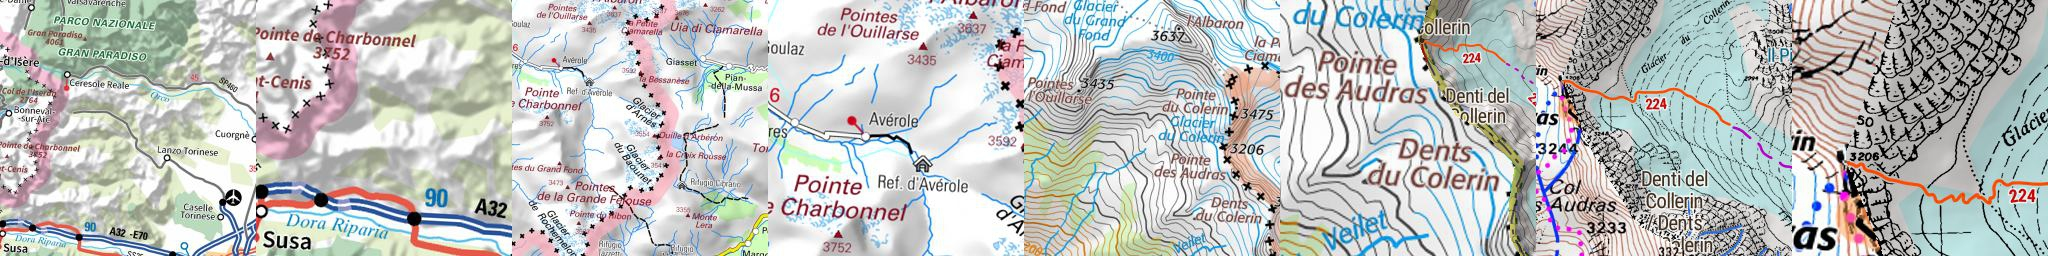

: 

In [ ]:
collerin = T.LngLat(7.11, 45.32)
MY.tile_pyramid('/tmp/a.jpg', ll=collerin, mbt=finalpath4)
display(DImage('/tmp/a.jpg'))

# Annex - inspection

b'\xff\xd8\xff\xe0\x00\x10JFIF'


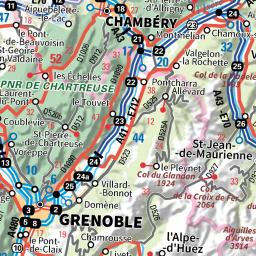

In [11]:
z, x, y, img = next(M.get_all_tiles(finalpath4))
print(img[:10])
display(DImage(img))

In [12]:
z, x, y, img = next(M.get_all_tiles(finalpath4))


In [13]:
import io
pim = Img.open(io.BytesIO(img))

In [14]:
bb = M.get_bounds(finalpath4)
bb

LngLatBbox(west=5.625, south=45.08904, east=8.4375, north=45.58329)

In [15]:
from src.jpg_quality_pil_magick import get_jpg_quality

In [16]:
# whi 45 kb/tile?
eps = 0.001
for lng, lat in ((bb.west+eps, bb.south+eps),(bb.west+eps, bb.north-eps),
                 (bb.east-1, bb.north-eps), (bb.east-1, bb.south+eps)):
    row = M.lnglat2tile(finalpath4, z=16, lng=lng, lat=lat, what='*')
    if row:
        pim = Img.open(io.BytesIO(row[-1]))
        print(row[:-1], get_jpg_quality(pim))
    else:
        print('?')


(16, 33792, 41984) 99
(16, 33792, 42111) 99
(16, 34121, 42111) 99
(16, 34121, 41984) 99


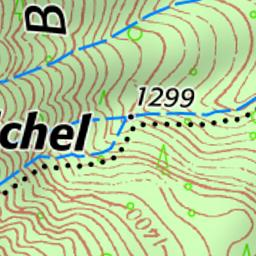

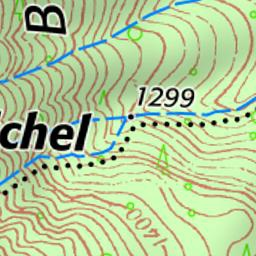

In [17]:
lng, lat = (bb.west+eps, bb.south+eps)
to = M.lnglat2tile(mbtfr4, z=16, lng=lng, lat=lat)
tn = M.lnglat2tile(finalpath4, z=16, lng=lng, lat=lat)
display(DImage(to))
display(DImage(tn))

In [18]:

pto = Img.open(io.BytesIO(to))
ptn = Img.open(io.BytesIO(tn))
print(len(to)//1024, len(tn) // 1024, '\n',
      get_jpg_quality(pto), get_jpg_quality(ptn) )

# quality 75 for source vs 99 for destination with 2x size bloat

18 37 
 75 99


In [ ]:
# operating in RGB space is 3x slower than greyscale
s = time()
(score, diff) = structural_similarity(np.array(pto),
                      np.array(ptn), channel_axis=2, full=True)
print(time() - s, score)

# x60: arbitrary mangification factor
Img.fromarray((diff * 255 * 60).astype(np.uint8))

0.01860809326171875

0.004150390625
0.9997361885691018


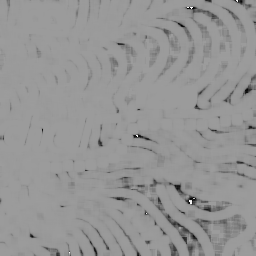

In [29]:
import skimage
from skimage.metrics import structural_similarity
s = time()
scoreg , diffg = structural_similarity(np.array(pto.convert('L')),
                      np.array(ptn.convert('L')), full=True)
print(time() - s)
print(scoreg)
Img.fromarray((diffg * 255 * 100).astype(np.uint8))

25910 b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00'
0.26139726217486897


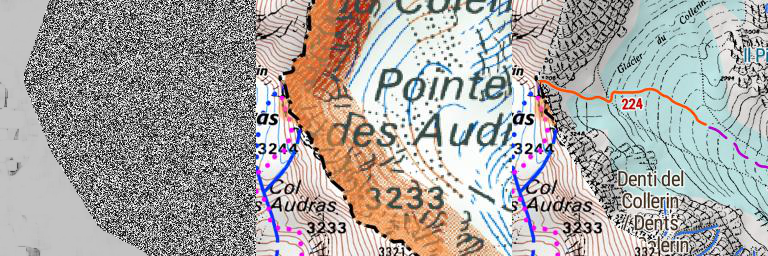

In [230]:
def ssim_xy(z, x, y, mbt_o, mbt_n, flip_y=False):
    to = M.xyz2tile(mbt_o, T.Tile(x, y, z), flip_y=flip_y)
    tn = M.xyz2tile(mbt_n, T.Tile(x, y, z), flip_y=flip_y)
    assert to
    assert tn
    print(len(to), to[:20])
    pto = Img.open(io.BytesIO(to))
    ptn = Img.open(io.BytesIO(tn))
    score , diff = structural_similarity(np.array(pto.convert('L')),
                      np.array(ptn.convert('L')), full=True)
    diff_img = Img.fromarray((diff * 255 * 60).astype(np.uint8))
    return score, G.pil_grid((diff_img, pto, ptn))

# def ssim(z, lng, lat, mbt_o, mbt_n):
#     to = M.lnglat2tile(mbt_o, z=z, lng=lng, lat=lat)
#     tn = M.lnglat2tile(mbt_n, z=z, lng=lng, lat=lat)
#     pto = Img.open(io.BytesIO(to))
#     ptn = Img.open(io.BytesIO(tn))
#     score , diff = structural_similarity(np.array(pto.convert('L')),
#                       np.array(ptn.convert('L')), full=True)
#     diff_img = Img.fromarray((diff * 255 * 60).astype(np.uint8))
#     return score, G.pil_grid((diff_img, pto, ptn))

def ssim(z, lng, lat, mbt_o, mbt_n):
    x, y, z = T.tile(lng, lat, z)
    return ssim_xy(z, x, y, mbt_o, mbt_n, flip_y=True)

ll_collerin = T.LngLat(7.11, 45.32)

score , img = ssim(15, ll_collerin.lng, ll_collerin.lat, mbtfr4, finalpath4)
print(score)
img
# -> difference is clear on the border (tiles we want to keep from source at highest quality)

19711 b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00'
0.32851189871483655


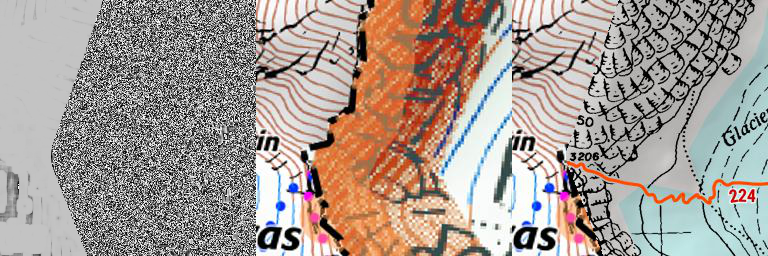

In [231]:
score , img = ssim(z=16, lng=ll_collerin.lng, lat=ll_collerin.lat, mbt_o=mbtfr4, mbt_n=finalpath4)
print(score)
img

20128 b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00'
0.7781307484092159


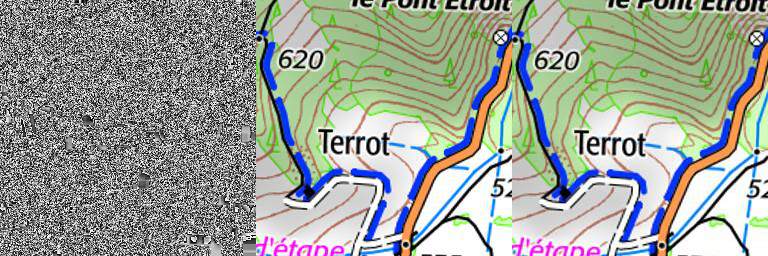

In [232]:
# unfortunately there's a real problem with a slight translation in alps3 :-(
score, img = ssim_xy(16, 33728, 41856, 'frit3/fr3.mbtiles', mbt3, flip_y=False)
print(score)
img

In [138]:
# design correct query for finding comparable tiles from the merged/fr/it databases:
with M.cursor(finalpath4) as dbc:
    dbc.execute('ATTACH ? AS help', (mbtfr4,))
    dbc.execute('ATTACH ? AS help2', (mbtitall,))
    q = """SELECT t0.zoom_level, t0.tile_column, t0.tile_row
            FROM main.tiles t0
            LEFT  JOIN help.tiles t1
                ON t0.zoom_level = t1.zoom_level
                AND t0.tile_column = t1.tile_column
                AND t0.tile_row = t1.tile_row
            LEFT  JOIN help2.tiles t2
                ON t0.zoom_level = t2.zoom_level
                AND t0.tile_column = t2.tile_column
                AND t0.tile_row = t2.tile_row
            LIMIT 10
            """
    print(dbc.execute(q).fetchall())
    q = """SELECT COUNT(*)
            FROM main.tiles t0
            LEFT  JOIN help.tiles t1
                ON t0.zoom_level = t1.zoom_level
                AND t0.tile_column = t1.tile_column
                AND t0.tile_row = t1.tile_row
            LEFT  JOIN help2.tiles t2
                ON t0.zoom_level = t2.zoom_level
                AND t0.tile_column = t2.tile_column
                AND t0.tile_row = t2.tile_row
            WHERE t0.zoom_level IN (15, 16)
            """
    print(dbc.execute(q).fetchone())

[(9, 264, 328), (9, 265, 328), (9, 266, 328), (9, 267, 328), (10, 528, 656), (10, 528, 657), (10, 529, 656), (10, 529, 657), (10, 530, 656), (10, 530, 657)]
(60759,)


# Execution


In [341]:

def mbt_recompress(fritN, zooms=(14, 15, 16), translate=False):
    workdir = f'frit{fritN}'
    MJD.process_tiles(pjoin(workdir, mbtnames_merged[fritN] + '.mbtiles'), pjoin(workdir, f'fr{fritN}.mbtiles'), mbtitall,
                q=f'WHERE main.tiles.zoom_level IN ({",".join(map(str, zooms))})',
                get_tiles_cbk=MJD.get_joined_tiles_3,
                merge_cbk=MJD.choose_similar(translate=translate))

In [ ]:
mbt1 = mbt_recompress(1)
# ~10 minutes
# reasons: 1:60891, skip:870, 2:28818


frit1/alps1-Mercantour-Ubaye-Cuneese-processed.mbtiles
#1/90579, z14: 
#1/90579, z14: 
#1001/90579, z14: Inserted 985 in 0.4s and copied 0 and removed 0 in 0.0s
#2001/90579, z14: 1:1862, skip:62, 2:76
#2001/90579, z14: merge_cbk:11.86, db_copyrm:0.0, db_insert:0.44
#2001/90579, z14: Inserted 953 in 0.6s and copied 0 and removed 0 in 0.0s
#3001/90579, z14: Inserted 975 in 0.4s and copied 0 and removed 0 in 0.0s
#4001/90579, z14: 1:2901, skip:121, 2:978
#4001/90579, z14: merge_cbk:23.92, db_copyrm:0.0, db_insert:1.4
#4001/90579, z14: Inserted 966 in 0.4s and copied 0 and removed 0 in 0.0s
#5001/90579, z15: Inserted 996 in 0.6s and copied 0 and removed 0 in 0.0s
#6001/90579, z15: 1:4525, skip:133, 2:1342
#6001/90579, z15: merge_cbk:34.41, db_copyrm:0.0, db_insert:2.33
#6001/90579, z15: Inserted 992 in 0.7s and copied 0 and removed 0 in 0.0s
#7001/90579, z15: Inserted 992 in 0.5s and copied 0 and removed 0 in 0.0s
#8001/90579, z15: 1:6509, skip:149, 2:1342
#8001/90579, z15: merge_cbk:45.17

In [ ]:
mbt3 = mbt_recompress(3, zooms=(9,), translate=True)  # only #1,4 don't have translation issue)
# ~7 minutes
 

frit3/alps3-Vercors-Ecrins-Queyras-Cozie-processed.mbtiles
#1/4, z9: 
#1/4, z9: 
Compacting...
finally merge_cbk:0.08
skip:4


In [197]:
mbt4 = mbt_recompress(4)
# ~7 minutes
# reasons: 1:42445, skip:517, 2:20837

frit4/alps4-Grenoble-Savoie-Susa-Lanzo-GParadiso-processed.mbtiles
#1/63799, z14: 
#1/63799, z14: 
#1001/63799, z14: Inserted 1000 in 0.1s and copied 0 and removed 0 in 0.0s
#2001/63799, z14: 1:1910, skip:30, 2:60
#2001/63799, z14: merge_cbk:10.82, db_copyrm:0.0, db_insert:0.14
#2001/63799, z14: Inserted 970 in 0.1s and copied 0 and removed 0 in 0.0s
#3001/63799, z14: Inserted 960 in 0.1s and copied 0 and removed 0 in 0.0s
#4001/63799, z15: 1:2956, skip:70, 2:974
#4001/63799, z15: merge_cbk:22.27, db_copyrm:0.0, db_insert:0.4
#4001/63799, z15: Inserted 1000 in 0.0s and copied 0 and removed 0 in 0.0s
#5001/63799, z15: Inserted 1000 in 0.0s and copied 0 and removed 0 in 0.0s
#6001/63799, z15: 1:4956, skip:70, 2:974
#6001/63799, z15: merge_cbk:32.87, db_copyrm:0.0, db_insert:0.45
#6001/63799, z15: Inserted 1000 in 0.0s and copied 0 and removed 0 in 0.0s
#7001/63799, z15: Inserted 1000 in 0.0s and copied 0 and removed 0 in 0.0s
#8001/63799, z15: 1:6956, skip:70, 2:974
#8001/63799, z15: mer

In [ ]:
mbt5 = mbt_recompress(5)
# 7 minutes, no gain, r=1:21939, skip:26544, 2:1517


frit5/alps5-Mont-Blanc-Leman-Cervino-Cogne-processed.mbtiles
#1/107506, z14: 
#1/107506, z14: 
#1001/107506, z14: Inserted 129 in 0.0s and copied 0 and removed 0 in 0.0s
#2001/107506, z14: 1:257, skip:1743
#2001/107506, z14: merge_cbk:9.17, db_copyrm:0.0, db_insert:0.04
#2001/107506, z14: Inserted 128 in 0.0s and copied 0 and removed 0 in 0.0s
#3001/107506, z14: Inserted 131 in 0.0s and copied 0 and removed 0 in 0.0s
#4001/107506, z14: 1:433, skip:3468, 2:99
#4001/107506, z14: merge_cbk:19.14, db_copyrm:0.0, db_insert:0.12
#4001/107506, z14: Inserted 144 in 0.0s and copied 0 and removed 0 in 0.0s
#5001/107506, z14: Inserted 143 in 0.0s and copied 0 and removed 0 in 0.0s
#6001/107506, z15: 1:937, skip:4811, 2:252
#6001/107506, z15: merge_cbk:25.93, db_copyrm:0.0, db_insert:0.14
#6001/107506, z15: Inserted 514 in 0.2s and copied 0 and removed 0 in 0.0s
#7001/107506, z15: Inserted 579 in 0.2s and copied 0 and removed 0 in 0.0s
#8001/107506, z15: 1:2086, skip:5662, 2:252
#8001/107506, z15:

OperationalError: database is locked

In [345]:
mbt1 = 'frit1/alps1-Mercantour-Ubaye-Cuneese-processed.mbtiles'
mbt3 = 'frit3/alps3-Vercors-Ecrins-Queyras-Cozie-processed.mbtiles'
mbt4 = 'frit4/alps4-Grenoble-Savoie-Susa-Lanzo-GParadiso-processed.mbtiles'
mbt5 = 'frit5/alps5-Mont-Blanc-Leman-Cervino-Cogne-processed.mbtiles'

In [368]:
from glob import glob
for path in sorted((
    # mbt1, mbt3, mbt4,
    *glob(f'frit*/alps*.mbtiles'),
)):
    print(M.mbt_info(path)[16:44], os.path.basename(path)[:-8] )




= 92072 * 21 kb/tile q = 75  alps1-Mercantour-Ubaye-Cuneese-processed
= 92072 * 30 kb/tile q = 95  alps1-Mercantour-Ubaye-Cuneese
= 68320 * 23 kb/tile q = 75  alps3-Vercors-Ecrins-Queyras-Cozie-processed
= 68648 * 37 kb/tile q = 95  alps3-Vercors-Ecrins-Queyras-Cozie
= 64814 * 23 kb/tile q = 75  alps4-Grenoble-Savoie-Susa-Lanzo-GParadiso-processed
= 64814 * 45 kb/tile q = 99  alps4-Grenoble-Savoie-Susa-Lanzo-GParadiso
= 109296 * 25 kb/tile q = 75 alps5-Mont-Blanc-Leman-Cervino-Cogne-processed
= 109296 * 25 kb/tile q = 75 alps5-Mont-Blanc-Leman-Cervino-Cogne


```
= 92072 * 21 kb/tile q = 75  alps1-Mercantour-Ubaye-Cuneese-processed
= 92072 * 30 kb/tile q = 95  alps1-Mercantour-Ubaye-Cuneese
= 68320 * 23 kb/tile q = 75  alps3-Vercors-Ecrins-Queyras-Cozie-processed
= 68648 * 37 kb/tile q = 95  alps3-Vercors-Ecrins-Queyras-Cozie
= 64814 * 23 kb/tile q = 75  alps4-Grenoble-Savoie-Susa-Lanzo-GParadiso-processed
= 64814 * 45 kb/tile q = 99  alps4-Grenoble-Savoie-Susa-Lanzo-GParadiso
= 109296 * 25 kb/tile q = 75 alps5-Mont-Blanc-Leman-Cervino-Cogne-processed
= 109296 * 25 kb/tile q = 75 alps5-Mont-Blanc-Leman-Cervino-Cogne
```

In [355]:
row = next(M.get_all_tiles(mbt3, q=f'WHERE zoom_level=16'))
row[:3],\
get_jpg_quality(Img.open(io.BytesIO(row[-1])))


((16, 33728, 41855), 95)

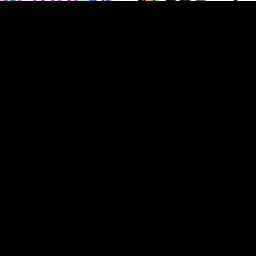

In [357]:
DImage(row[-1])

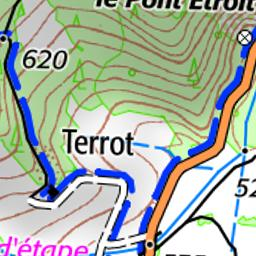

In [360]:
DImage(M.xyz2tile(mbt3, T.Tile(33728, 41856, 16), flip_y=False))

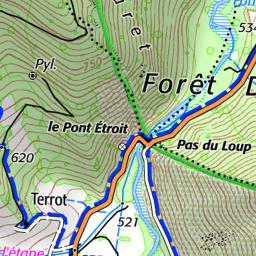

In [362]:
DImage(M.xyz2tile(mbt3, T.Tile(16864, 20928, 15), flip_y=False))
#DImage(M.xyz2tile(mbt3, T.Tile(16864, 20927, 15), flip_y=False))

`16864, 20927, 15` does not exist, there is a shift down only on level 16

In [364]:
with M.cursor(mbt3) as c:
    c.execute('DELETE FROM tiles WHERE zoom_level=16 AND tile_row=41855')

In [366]:
print(M.get_bounds(mbt3))
M.set_real_bounds(mbt3)
print(M.get_bounds(mbt3))

LngLatBbox(west=4.92188, south=44.58656, east=7.73438, north=45.08904)
LngLatBbox(west=4.92188, south=44.59047, east=7.73438, north=45.08904)


In [ ]:
M.get_bounds()

# Upload

In [ ]:
mbtsprocessed = {
    1: 'frit1/alps1-Mercantour-Ubaye-Cuneese-processed.mbtiles',
    3: 'frit3/alps3-Vercors-Ecrins-Queyras-Cozie-processed.mbtiles',
    4: 'frit4/alps4-Grenoble-Savoie-Susa-Lanzo-GParadiso-processed.mbtiles',
    5: 'frit5/alps5-Mont-Blanc-Leman-Cervino-Cogne-processed.mbtiles',
}
# mbtsfinal = {fritN: f'frit{fritN}/{mbtnames_merged[fritN]}.mbtiles' for fritN in mbtnames_merged}
mbtsfinal = {fritN: f'../../mapdata/mbtiles/{mbtnames_merged[fritN]}.mbtiles' for fritN in mbtnames_merged}

for fritN, mbtnew in mbtsprocessed.items():
    mbtorig = mbtsfinal[fritN]
    print(M.mbt_info(mbtorig))
    print(M.mbt_info(mbtnew))
    print()

In [375]:
for fritN, mbtnew in mbtsprocessed.items():
    mbtorig = mbtsfinal[fritN]
    print('mv', mbtnew, mbtorig)

mv frit1/alps1-Mercantour-Ubaye-Cuneese-processed.mbtiles ../../mapdata/mbtiles/alps1-Mercantour-Ubaye-Cuneese.mbtiles
mv frit3/alps3-Vercors-Ecrins-Queyras-Cozie-processed.mbtiles ../../mapdata/mbtiles/alps3-Vercors-Ecrins-Queyras-Cozie.mbtiles
mv frit4/alps4-Grenoble-Savoie-Susa-Lanzo-GParadiso-processed.mbtiles ../../mapdata/mbtiles/alps4-Grenoble-Savoie-Susa-Lanzo-GParadiso.mbtiles
mv frit5/alps5-Mont-Blanc-Leman-Cervino-Cogne-processed.mbtiles ../../mapdata/mbtiles/alps5-Mont-Blanc-Leman-Cervino-Cogne.mbtiles


In [382]:
mbtf1 = mbtsfinal[1]
mbtf3 = mbtsfinal[3]
mbtf4 = mbtsfinal[4]
mbtf5 = mbtsfinal[5]

In [380]:

!gh release upload 202301 $mbtf1 $mbtf3 $mbtf4

Successfully uploaded 3 assets to 202301


In [383]:
!gh release upload 202301 $mbtf5

HTTP 422: Validation Failed (https://uploads.github.com/repos/eslopemap/etopo/releases/89815977/assets?label=&name=alps5-Mont-Blanc-Leman-Cervino-Cogne.mbtiles)
size must be less than or equal to 2147483648


# Annex: Investigation of translation issue

gdal has translated french side by 1 pixel down

20128 b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00'
0.7781307484092159


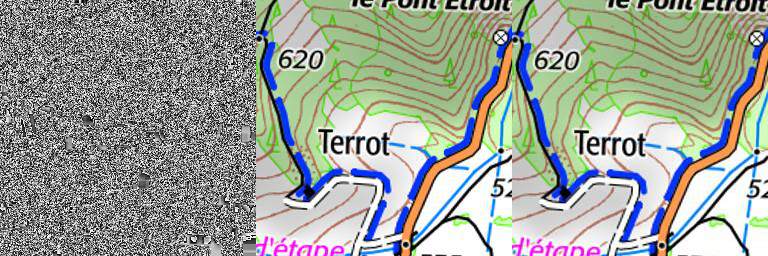

In [229]:
score, img = ssim_xy(16, 33728, 41856, 'frit3/fr3.mbtiles', mbt3, flip_y=False)
print(score)
img

In [285]:
def imdebug(theim, zoom=1):
	h, w = theim.shape
	return Img.fromarray(theim).resize((w*zoom, h*zoom), Img.Resampling.NEAREST).convert('RGB')

def pimdebug(pim:Img.Image, zoom=2):
	w, h = pim.width, pim.height
	return pim.resize((w*zoom, h*zoom), Img.Resampling.NEAREST)


In [312]:
mbt3 = 'frit3/alps3-Vercors-Ecrins-Queyras-Cozie-processed.mbtiles'
z, x, y = 16, 33754, 41897
# z, x, y = 16, 33728, 41856
to = M.xyz2tile('frit3/fr3.mbtiles', T.Tile(x, y, z), flip_y=False)
tn = M.xyz2tile(mbt3, T.Tile(x, y, z), flip_y=False)
pto = Img.open(io.BytesIO(to))
ptn = Img.open(io.BytesIO(tn))

ima1 = G.to_numpy(pto.convert('L'))
ima2 = G.to_numpy(ptn.convert('L'))

ima1.shape

(256, 256)

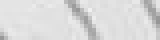

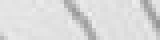

In [297]:
display(imdebug(ima1[-10:, :40], 4))
display(imdebug(ima2[-10:, :40], 4))

In [315]:
a = ima1[:6, :6]
print(a)

print(a[2:-2,2:-2])

for dx in range(5):
    for dy in range(5):
        print(a[dx:6-(4-dx), dy:6-(4-dy)], dx, dy)



[[232 231 222 220 227 234]
 [236 234 226 224 228 235]
 [235 234 231 231 231 219]
 [221 214 204 200 199 182]
 [190 173 154 146 147 142]
 [155 147 142 140 131 116]]
[[231 231]
 [204 200]]
[[232 231]
 [236 234]] 0 0
[[231 222]
 [234 226]] 0 1
[[222 220]
 [226 224]] 0 2
[[220 227]
 [224 228]] 0 3
[[227 234]
 [228 235]] 0 4
[[236 234]
 [235 234]] 1 0
[[234 226]
 [234 231]] 1 1
[[226 224]
 [231 231]] 1 2
[[224 228]
 [231 231]] 1 3
[[228 235]
 [231 219]] 1 4
[[235 234]
 [221 214]] 2 0
[[234 231]
 [214 204]] 2 1
[[231 231]
 [204 200]] 2 2
[[231 231]
 [200 199]] 2 3
[[231 219]
 [199 182]] 2 4
[[221 214]
 [190 173]] 3 0
[[214 204]
 [173 154]] 3 1
[[204 200]
 [154 146]] 3 2
[[200 199]
 [146 147]] 3 3
[[199 182]
 [147 142]] 3 4
[[190 173]
 [155 147]] 4 0
[[173 154]
 [147 142]] 4 1
[[154 146]
 [142 140]] 4 2
[[146 147]
 [140 131]] 4 3
[[147 142]
 [131 116]] 4 4


In [306]:
scores = {}
diffs = {}

for dx in range(5):
    for dy in range(5):
        # if not dx**2 + dy**2:
        #     continue

        ima1in = ima1[2:-2, 2:-2]
        ima2in = ima2[dx:256-(4-dx), dy:256-(4-dy)]
        score , diff = structural_similarity(ima1in, ima2in, full=True)
        scores[(dx, dy)] = round(score, 2)
        diffs[(dx, dy)] = diff
        
    #     diff_img = Img.fromarray((diff * 255 * 60).astype(np.uint8))
    # return score, G.pil_grid((diff_img, pto, ptn))

scores

{(0, 0): 0.46,
 (0, 1): 0.5,
 (0, 2): 0.47,
 (0, 3): 0.38,
 (0, 4): 0.29,
 (1, 0): 0.52,
 (1, 1): 0.63,
 (1, 2): 0.63,
 (1, 3): 0.49,
 (1, 4): 0.34,
 (2, 0): 0.54,
 (2, 1): 0.76,
 (2, 2): 0.85,
 (2, 3): 0.65,
 (2, 4): 0.41,
 (3, 0): 0.5,
 (3, 1): 0.79,
 (3, 2): 1.0,
 (3, 3): 0.79,
 (3, 4): 0.5,
 (4, 0): 0.41,
 (4, 1): 0.65,
 (4, 2): 0.86,
 (4, 3): 0.76,
 (4, 4): 0.53}

In [319]:
MJD.choose_similar(z, x, y, to, tn, None, True)[2],\
MJD.choose_similar(z, x, y, tn, to, None, True)[2],

('t=(2, 1) s=0.99581 q=95', 't=(0, 1) s=0.99582 q=75')

In [324]:
z=16
with MD.catchtime() as ti:
    for x in range(33728, 34829, 100):
        for y in range(41856, 42957, 100):
            _to = M.xyz2tile(mbt3, T.Tile(x, y, z), flip_y=False)
            _tn = M.xyz2tile('frit3/fr3.mbtiles', T.Tile(x, y, z), flip_y=False)
            if _to and _tn:
                print(x, y, MJD.choose_similar(z, x, y, _to, _tn, None, True)[2])
ti.time

33728 41856 t=(0, 1) s=0.99676 q=75
33728 41956 t=(0, 1) s=0.99627 q=75
33828 41856 t=(0, 1) s=0.99642 q=75
33828 41956 t=(0, 1) s=0.99691 q=75
33928 41856 t=(0, 1) s=0.99732 q=75
33928 41956 t=(0, 1) s=0.99888 q=75
34028 41856 s=[0.12511026679824747, -1] q=80
34028 41956 s=[0.19205589028767947, -1] q=80


0.11824657299439423

In [384]:
GY.alps2geojson('../data/areas/etopo_alps_extents.geojson')